In [1]:
import scipy.io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.ndimage import binary_closing, median_filter, label

# Function to load data
def load_data(file_path):
    # Load .mat file
    data = scipy.io.loadmat(file_path)
    return data[list(data.keys())[3]], data[list(data.keys())[4]], data[list(data.keys())[5]]

# Visualization functions
def show_image(image, title):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()

def show_point_cloud(pc):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pc[:, :, 0], pc[:, :, 1], pc[:, :, 2], s=1)
    ax.set_title('3D Point Cloud')
    plt.show()

# Load your data
amplitude_image, distance_image, point_cloud = load_data('data/example2kinect.mat')


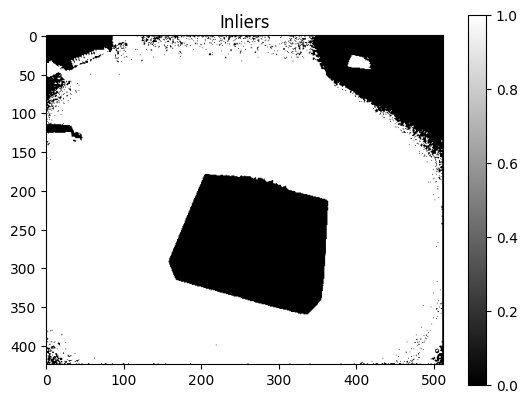

In [2]:
flattened_point_cloud = point_cloud.reshape(-1, 3)

def calculate_plane_distance(samples):
    centroid = np.mean(samples, axis=0)
    # subtract centroid from each points, so that centroid is the origin
    centered_points = samples - centroid
    _, _, v = np.linalg.svd(centered_points)
    # last row of v is the plane normal and dot product of plane normal and centroid acts as an offset (d) from the origin to the plane
    return v[2], np.dot(v[2], centroid)

def distance_to_plane(pc, normal_vector, d):
    return np.dot(pc, normal_vector) - d

def ransac_point_cloud(pc, threshold, max_iterations):
    best_plane = None
    best_inliers = []

    for _ in range(max_iterations):
        # Randomly sample 3 points to define a plane
        sample_indices = np.random.choice(pc.shape[0], 3, replace=False)
        samples = pc[sample_indices]

        if np.any(samples[:, 2] == 0):  # Skip if any z-component is zero (invalid data)
            continue

        # Calculate plane parameters
        normal_vector, d = calculate_plane_distance(samples)

        # Count inliers
        distances = distance_to_plane(pc, normal_vector, d)
        inliers = distances < threshold

        # Update best model if current one has more inliers
        inliers = np.where(np.abs(distances) < threshold)[0]
        if len(inliers) > len(best_inliers):
            best_plane = (normal_vector, d)
            best_inliers = inliers

    return best_plane, best_inliers

# Run RANSAC
threshold = 0.05
max_iterations = 100
plane, inliers = ransac_point_cloud(flattened_point_cloud, threshold, max_iterations)

first_plane_normal, first_plane_d = plane

# Calculate the distances from points to the floor plane
first_distance_to_plane = distance_to_plane(flattened_point_cloud, first_plane_normal, first_plane_d)
first_mask = np.abs(first_distance_to_plane) < threshold
first_mask = first_mask.reshape(point_cloud.shape[:2])
first_mask_outliers = flattened_point_cloud[np.abs(first_distance_to_plane) > threshold]
show_image(first_mask, 'Inliers')

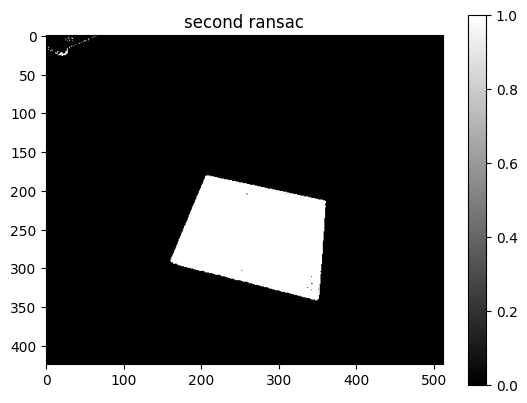

In [3]:
threshold_box = 0.006

second_plane, second_inliers = ransac_point_cloud(first_mask_outliers, threshold_box, max_iterations)
second_plane_normal, second_plane_d = second_plane
second_distance_to_plane = distance_to_plane(flattened_point_cloud, second_plane_normal, second_plane_d)

#Generate a Mask for Inliers "True"==inlier=="Top of the box" & "False"==outlier=="rest"
second_mask = np.abs(second_distance_to_plane) < threshold_box

second_mask = second_mask.reshape(point_cloud.shape[:2])
second_mask_inliers = flattened_point_cloud[np.abs(second_distance_to_plane) > threshold_box]
show_image(second_mask,"second ransac")

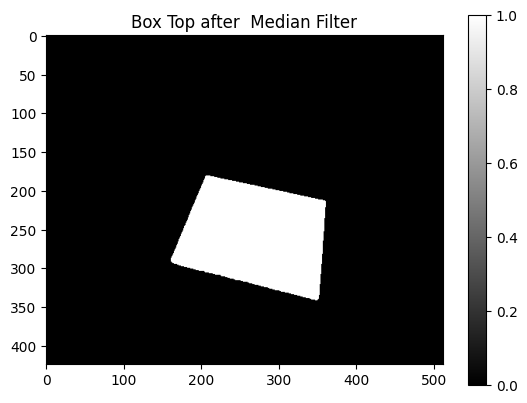

In [4]:
kernel_size =3
iterations = 5

structure = np.ones((kernel_size, kernel_size))

closed_mask = binary_closing(second_mask, structure=structure, iterations=iterations)
#we used other morphological operators, closing was the best
processed_mask = closed_mask

# Add Median Filter
median_filtered_mask = median_filter(processed_mask, size=kernel_size)

# Find the largest connected component
# label function is used to label the connected components in a binary image.
labeled_array, num_features = label(median_filtered_mask, structure=structure)
unique, counts = np.unique(labeled_array, return_counts=True)
# By excluding the first element ([1:]), the code focuses on the actual features/components not the background
largest_component_label = unique[1:][np.argmax(counts[1:])]
box_top = (labeled_array == largest_component_label)

show_image(box_top, "Box Top after  Median Filter")
